In [1]:
# This code is used as a baseline for comparing diffetent types of privacy-preservation techniques.

In [2]:
# Improting the required libraries.
import numpy as np

from matplotlib import pyplot as plt

from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

# ours
from approach.lstm_forecast import ShallowForecastLSTM
from util.utils import train_one_step, test_model, predict, SequenceDataset
from util.fed_utils import FedAvg_loop

### Introduction

- Context: time series data, decentralized on "nodes".
- Constraints: the nodes cannot exchange their data.
- Goal: train a predictive model (here forecasting) on each node.

Federated learning: take advantage of the parameters of the models of the other nodes to improve the predictive capacities of each model (local). # FedAvg reference + two-sentence description

### Plan

In [3]:
# performance boxplots

#### 0. Data: time series (one per node)

A time series is a sequence of measurements indexed by time. When at each of these instants of time, a single state variable is measured (e.g. temperature, frequentation of a bus station, etc.), the time series is said to be univariate. A fortiori, when several variables are measured at a given moment, we say that the time series is multivariate (or multivalued).

We note $x_k(t)$ the sample measured on the variable $k$ at time $t$ for $k = 1 \dots K$ and $t = 0, \dots T$.

Often, when we study a multivariate time series, we conjecture that the variables $K$ (or a subset) are correlated with each other over time, that is to say that the variables $x_{k_1}$ and $x_{k_2}$ evolve together. In this case, it assumes that to predict the future value $x_{k_1}(T+1)$ (unmeasured) from its past values $x_{k_1}(t=0) \dots x_{k_1}( t=T)$, we must also consider the passed values $x_{k_2}(t=0) \dots x_{k_2}(t=T)$.

#### 1. The prediction model (forecasting)

Here, we want to train a model to predict the future values of each of the variables (forecasting), i.e. give an estimate of $x_{1}(T+1), \dots x_{k}(T +1) \dots x_{K}(T+1)$. Each model $k$ (a Long Short Term Memory type neural network) will then attempt to approximate a function $f_k$ such that $x_{t+1} = f_k (x_t, \dots x_{t-1} \ dots )$. The prediction function $f_k$ represents the model $k$ and has, say $p$ parameters $w_{1,k}, \dots w_{1,p}$.

#### 2. Federated learning context

In our context, we assume that the data of a variable $k$ are measured on a node $k$. This data cannot be communicated and shared with other nodes. It is therefore impossible to build a global model from the data of all the variables. We will therefore train one model per node. In order to take these possible correlations into consideration, each model can be trained by sharing not the data but the parameters of each model with a central server. A simple strategy, called Federated Averaging, consists of averaging the parameters of each of the models, more concretely:
- (1.) the local model $k$ learns on its data $x_{k}(t=0) \dots x_{k}(t=T)$,
- (2.) the model $k$ sends its parameters, say $w_{1,k}, \dots w_{p,k}$ to the central server,
- (3.) the central server calculates the average $w_{1}^c, \dots w_{p}^c$ of the $p$ parameters of the $K$ models: e.g. for a parameter $w_{p}^c = \frac{1}{K} \sum_{i=1}^{K} w_{p,i}$,
- (4.) the central server returns the averaged parameters to node $k$,
- (5.) the local model $k$ receives the parameters $w_{1}^c, \dots w_{p}^c$, and starts again at step (1.).

Bibliographic reference of the Federated Averaging algorithm: H. B. McMahan, E. Moore, D. Ramage, S. Hampson, and B. Agüera y Arcas, “Communication-Efﬁcient Learning of Deep Networks from Decentralized Data,” in AISTATS, 2017, vol. 54.

### Purpose of the notebook:
- apply Federated Averaging to predict over time (forecaster) on each node,
- compare to non-federated learning (the nodes do not communicate with each other),
- compare to "classical" centralized learning, where the data for each of the variables is not distributed and is used to train a single model on a "big" multivariate time series.

### Application and comparison

Here it is assumed that each node contains data from a single time series.

In [4]:
x_data = np.load("./datasets/electricity.npy")
T_size, p = x_data.shape # output is (10560, 963)
n_clients = 10 # 50 # reduced number for the example
t_grid = np.arange(0, T_size) # output is array([    0,     1,     2, ..., 10557, 10558, 10559])

# common to all experiments
T_train = int(0.70 * T_size) # output is 7391
lag = 40 # number of time-consecutive samples within a mini batch

In [5]:
import pandas as pd
tmp = pd.DataFrame(x_data)
tmp

,0,1,2,3,4,5,6,7,8,9,...,360,361,362,363,364,365,366,367,368,369
0,16.497462,91.038407,309.296264,552.845528,289.024390,1392.857143,34.482759,1117.845118,291.958042,351.612903,...,482.512491,103900.0,6042.194093,6636.363636,62.581486,51.492101,2096.575944,243.739566,2854.105572,0.000000
1,19.035533,92.460882,309.296264,548.780488,280.487805,1357.142857,27.699265,1104.377104,269.230769,329.032258,...,451.106353,95500.0,4388.185654,6613.636364,63.885267,42.129901,2200.175593,245.409015,2823.313783,0.000000
2,16.497462,91.749644,309.296264,546.747967,265.853659,1145.833333,26.568683,959.595960,255.244755,288.172043,...,410.421128,96600.0,4278.481013,6568.181818,63.885267,38.619075,1996.488147,203.672788,2756.598240,0.000000
3,19.035533,88.193457,309.296264,408.536585,201.219512,767.857143,19.219898,801.346801,166.083916,184.946237,...,259.814418,93400.0,4168.776371,6318.181818,73.011734,38.619075,1320.456541,188.647746,2724.340176,0.000000
4,17.766497,87.482219,309.296264,327.235772,180.487805,622.023810,14.132278,720.538721,183.566434,169.892473,...,295.503212,90300.0,4130.801688,6272.727273,62.581486,35.108250,1314.310799,190.317195,2741.202346,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,7.614213,110.241821,6.950478,821.138211,385.365854,1532.738095,47.484454,1380.471380,412.587413,343.010753,...,1501.784440,163700.0,8776.371308,9568.181818,284.224250,19.894675,1840.210711,160.267112,2764.662757,34918.918919
26300,8.883249,97.439545,6.950478,713.414634,359.756098,1324.404762,45.223290,1188.552189,351.398601,313.978495,...,1317.630264,157900.0,6586.497890,8340.909091,298.565841,16.383850,1357.330992,525.876461,2722.873900,32864.864865
26301,10.152284,90.327169,6.950478,650.406504,351.219512,1267.857143,46.353872,1074.074074,293.706294,276.344086,...,1309.064954,154200.0,6590.717300,5704.545455,294.654498,17.554125,2047.410009,661.101836,2647.360704,33189.189189
26302,8.883249,88.193457,6.950478,630.081301,339.024390,1247.023810,45.223290,1026.936027,283.216783,292.473118,...,1178.443969,133100.0,6514.767932,5454.545455,220.338983,30.427150,2796.312555,784.641068,2709.677419,30108.108108


In [6]:
n_epoch = 20 # 100
batch_size = 2**3

Graphs of the data of some nodes $x_0 \dots x_{15}$ as a function of time.

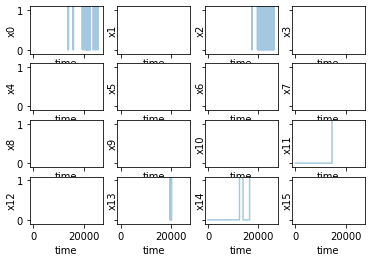

In [7]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True)
axs = axs.ravel()

axs[0].set_ylim((-0.1, 1.1))
for k in range(16): # 16 clients (nodes)
    axs[k].plot(
        t_grid, x_data[:, k],
        alpha=0.4
        )
    axs[k].set_ylabel(f'x{k}', labelpad=-0.5)
    axs[k].set_xlabel('time')

In [8]:
x_data[:, 2]

array([309.29626412, 309.29626412, 309.29626412, ...,   6.95047785,
         6.95047785,   6.95047785])

In [9]:
x_data[:T_train, 1].shape

(18412,)

In [10]:
x_data[T_train:, 1].shape

(7892,)

In [11]:
# Contents

#### I. NON-federated workouts

Objective: for each indexed variable $k$, $x_1 \dots x_{K}$, we want to train a model that predicts $x_k(t+1)$ according to its past values $x_k(t), x_k(t-1 ), \dots$

Here we train one model per node, independently of the (data and models) of the other nodes.

We start by creating one dataset per variable (which is naturally the case in a federated context). Each dataset is then divided into two sets training/testing then centered-reduced.

In [12]:
train_loaders, test_loaders = [], []

# one scaler for each node
scalers =  [StandardScaler(with_mean=True, with_std=True) for k in range(n_clients)]

for k in range(n_clients):
    
    train_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].fit_transform(x_data[:T_train, k][:, np.newaxis]), # center-reduce train data of client k
                lag=lag
            ),
            batch_size=batch_size, shuffle=True
        )
    )

    test_loaders.append(
        DataLoader(
            SequenceDataset(
                scalers[k].transform(x_data[T_train:, k][:, np.newaxis]),
                lag=lag
            ),
            batch_size=batch_size, shuffle=False # makes the data same when batches are requested at different times
        )
    )

We choose a one-layer Long Short Time Memory (LSTM) recurrent neural network model with a small number of neurons (for the example). Each node will have the same model architecture but will be trained on its own data only.

In [13]:
# desgin the model
num_hidden_units = 5 # 50
models_nofed = [ShallowForecastLSTM(num_var=1, hidden_units=num_hidden_units) for k in range(n_clients)]

Finally, we fix the training procedure which itself involves the choice of an error function to minimize, a minimizer, a learning step, etc.

In [14]:
# train the models
loss_function = nn.MSELoss()
learning_rate = 1e-2

optimizers = [Adam(
    models_nofed[k].parameters(),
    lr=learning_rate,
    betas=(0.60, 0.75),
    weight_decay=1e-2
) for k in range(n_clients)]

# self-tuning of the learning step at each iteration on each client
schedulers = [ReduceLROnPlateau(optimizers[k], 'min', patience = 7) for k in range(n_clients)]

# 
train_loss_epoch = np.empty((n_epoch, n_clients))
test_loss_epoch = np.empty_like(train_loss_epoch)

# for each client
for k in range(n_clients):
    print(f'==Learning model of node#{k}==')

    # for each learning step
    for i_epoch in range(n_epoch):
        print(f'------\n Epoch {i_epoch}')

        # train
        train_loss_epoch[i_epoch, k], model_k = train_one_step(
            train_loaders[k], models_nofed[k], loss_function, optimizer=optimizers[k]
            )

        # test
        test_loss_epoch[i_epoch, k] = test_model(
            test_loaders[k], models_nofed[k], loss_function, verbose=True)

        # learning rate decay
        schedulers[k].step(test_loss_epoch[i_epoch, k])
        
        if i_epoch == n_epoch - 1:
            models_nofed[k] = deepcopy(models_nofed[k])


==Learning model of node#0==
------
 Epoch 0
Train loss: 0.2485023853866174
Test loss: 0.1473886128788646
------
 Epoch 1
Train loss: 0.23651054602898786
Test loss: 0.12684113604058828
------
 Epoch 2
Train loss: 0.23507260594113027
Test loss: 0.12978760096764197
------
 Epoch 3
Train loss: 0.23388888958003493
Test loss: 0.1253656660469317
------
 Epoch 4
Train loss: 0.2348866680291397
Test loss: 0.12785210226042754
------
 Epoch 5
Train loss: 0.23444748982434346
Test loss: 0.12533033463710047
------
 Epoch 6
Train loss: 0.2345418173539969
Test loss: 0.1328811846962345
------
 Epoch 7
Train loss: 0.23732411619172641
Test loss: 0.1278140492090463
------
 Epoch 8
Train loss: 0.23546931709524577
Test loss: 0.1428352495449715
------
 Epoch 9
Train loss: 0.23588632307022236
Test loss: 0.12823652503401015
------
 Epoch 10
Train loss: 0.23641618035468098
Test loss: 0.14000531055446971
------
 Epoch 11
Train loss: 0.2339176485672707
Test loss: 0.1278454090274914
------
 Epoch 12
Train loss: 0.

Train loss: 0.17191173417613453
Test loss: 0.15405850828999867
------
 Epoch 2
Train loss: 0.17180913294156566
Test loss: 0.15564017309576061
------
 Epoch 3
Train loss: 0.17203382486404672
Test loss: 0.15202636190943924
------
 Epoch 4
Train loss: 0.17222563412160224
Test loss: 0.15161383551712457
------
 Epoch 5
Train loss: 0.17166499519756276
Test loss: 0.16555151424683034
------
 Epoch 6
Train loss: 0.1724162239635559
Test loss: 0.15553355381353226
------
 Epoch 7
Train loss: 0.17177847569418359
Test loss: 0.15414884002556553
------
 Epoch 8
Train loss: 0.17226295560059485
Test loss: 0.14280674787919512
------
 Epoch 9
Train loss: 0.17224921349643993
Test loss: 0.15183598998737763
------
 Epoch 10
Train loss: 0.1725497352714682
Test loss: 0.1549940385951037
------
 Epoch 11
Train loss: 0.1720143011597177
Test loss: 0.1512547939045783
------
 Epoch 12
Train loss: 0.17161266768851247
Test loss: 0.15177284134504704
------
 Epoch 13
Train loss: 0.1720293051070436
Test loss: 0.149893372

In [15]:
# average testing loss (across clients) along the iterations
print('Global testing loss')
np.average(test_loss_epoch, axis=1, weights=np.ones(n_clients))

Global testing loss


array([0.14519991, 0.14477948, 0.13965906, 0.13714089, 0.13847345,
       0.14346855, 0.13668036, 0.13775939, 0.13753028, 0.14160149,
       0.13758569, 0.13638099, 0.13693133, 0.13872208, 0.14075255,
       0.13728805, 0.13859964, 0.13535595, 0.13491711, 0.13737259])

Visualization of training/test errors per node.

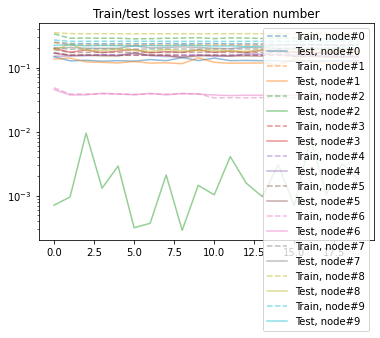

In [16]:
for k in range(n_clients):
    # make a function
    plt.plot(train_loss_epoch[:, k], label=f'Train, node#{k}', color=f'C{k}', alpha=0.5, linestyle='dashed')
    plt.plot(test_loss_epoch[:, k], label=f'Test, node#{k}', color=f'C{k}', alpha=0.5, linestyle='solid')

plt.title('Train/test losses wrt iteration number')
plt.yscale('log')
plt.legend()
plt.show()

Visualization of predictions/true values on training/test sets.

In [17]:
t_train, t_test = np.arange(0, T_train), np.arange(T_train, T_size)

In [18]:
def plot_client_pred_truth(idx_client, models, train_samples=True, timesteps=t_train):
    """plot samples vs predictions"""

    # compute prediction
    if train_samples:
        x_pred = scalers[k].inverse_transform(predict(train_loaders[k], models[k]).numpy())
    else:
        x_pred = scalers[k].inverse_transform(predict(test_loaders[k], models[k]).numpy())

    # plot the time series
    if train_samples:
        plt.plot(timesteps, x_data[:T_train, idx_client], marker='o', label='Truth', color='C0', alpha=0.25)
    else:
        plt.plot(timesteps, x_data[T_train:, idx_client], label='Truth',  marker='o', color='C0', alpha=0.25)

    plt.plot(timesteps, x_pred, label='Prediction', color='red', alpha=0.25)
    plt.legend(); plt.show()

Graph of the time series (test data) of the customer $k$ and the associated predictions of the model $k$.

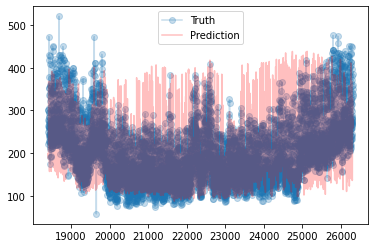

In [19]:
plot_client_pred_truth(
    idx_client=4,
    models=models_nofed,
    train_samples=False,
    timesteps=t_test
    )

### II. Federated training

Objective: for each indexed variable $k$, $x_1 \dots x_{K}$, we want to train a model that predicts $x_k(t+1)$ according to its past values $x_k(t), x_k(t-1 ), \dots$ in the federated context. The local models (nodes) are first trained independently of each other (as in I.), then they share their model (weight of the LSTM) with the central server (federator) which itself aggregates the models (weight $\ textit of $LSTM). This aggregated model is returned to each client that iterates training locally.

This iterative process, called “communication round”, between the local nodes and the central server, can be repeated several times (n_cr times).
n_cr: number of communication rounds.

In [20]:
models_fed, local_losses_bfr_fedavg, local_losses_aft_fedavg, global_loss  = FedAvg_loop(
    call_basemodel=ShallowForecastLSTM,
    archi_basemodel={'n_inputs': 1, 'n_hidden': 10},
    train_sets=train_loaders,
    test_sets=test_loaders,
    n_cr=5, n_local_epochs=n_epoch,
    lr= 10**-2
)

Communication round 0
-------------------
**Learning client#0
--------------
Train loss: 0.2691654739981326
Train loss: 0.2311674348253974
Train loss: 0.22648852701729963
Train loss: 0.22273680989056635
Train loss: 0.21972523156514465
Train loss: 0.21811335707238802
Train loss: 0.21683860109216488
Train loss: 0.21576205129489093
Train loss: 0.21470360228743082
Train loss: 0.213952100986949
Train loss: 0.21347918619749076
Train loss: 0.21268166364387056
Train loss: 0.21242561224424447
Train loss: 0.2118181364139365
Train loss: 0.2114187017142387
Train loss: 0.21087764102216025
Train loss: 0.2102342440894292
Train loss: 0.20958479670547783
Train loss: 0.2093299831088036
Train loss: 0.20900686779915642
**Client test loss before FedAvg 0.8198871095952593
**Client test loss after FedAvg 0.11847390149261311

--------------
**Learning client#1
--------------
Train loss: 0.37331111064798916
Train loss: 0.22923113817193722
Train loss: 0.22111657060392292
Train loss: 0.21674712721442888
Train lo

Train loss: 0.2058468941973561
Train loss: 0.20528221463520188
Train loss: 0.20484581680024339
Train loss: 0.20458023363782407
Train loss: 0.20397422134979012
Train loss: 0.20355416967549306
Train loss: 0.20300981973785504
Train loss: 0.2027852304467576
Train loss: 0.20256208272911888
Train loss: 0.20224354774207703
Train loss: 0.20194935210421458
Train loss: 0.20201453226079377
Train loss: 0.20261854127713044
Train loss: 0.2018113272646869
Train loss: 0.20128005484197342
Train loss: 0.2011206082458188
**Client test loss before FedAvg 0.11847390149261311
**Client test loss after FedAvg 0.115491311306232

--------------
**Learning client#1
--------------
Train loss: 0.18740232680199245
Train loss: 0.18659595897009387
Train loss: 0.18535847130185437
Train loss: 0.18450266549842745
Train loss: 0.183489483529718
Train loss: 0.18245369889453816
Train loss: 0.18149762859990373
Train loss: 0.17986711660209076
Train loss: 0.17872243928362969
Train loss: 0.17694776243828383
Train loss: 0.175720

Train loss: 0.19958813171107548
Train loss: 0.19988471403019908
Train loss: 0.19920091170714044
Train loss: 0.19959348614151015
Train loss: 0.19893554148816872
Train loss: 0.1990287495978993
Train loss: 0.1985794181739803
Train loss: 0.19870260473086174
Train loss: 0.19833069080336696
Train loss: 0.19829945874210894
Train loss: 0.19782989042721383
**Client test loss before FedAvg 0.115491311306232
**Client test loss after FedAvg 0.11425221273179587

--------------
**Learning client#1
--------------
Train loss: 0.15931175972519526
Train loss: 0.15834033789499935
Train loss: 0.15767320032254975
Train loss: 0.15620896563263242
Train loss: 0.15578193304175067
Train loss: 0.15558713089171425
Train loss: 0.1544904488055513
Train loss: 0.153557513653787
Train loss: 0.15312320968614798
Train loss: 0.15231922437098253
Train loss: 0.15157778272317274
Train loss: 0.1511262498762002
Train loss: 0.15040526318272412
Train loss: 0.149831861508286
Train loss: 0.14927382467919031
Train loss: 0.14879653

Train loss: 0.19556618978436133
Train loss: 0.19581543236155083
Train loss: 0.1954892275850242
Train loss: 0.19562931438585537
Train loss: 0.19544158840064363
Train loss: 0.19739575751838767
**Client test loss before FedAvg 0.11425221273179587
**Client test loss after FedAvg 0.11442950180252628

--------------
**Learning client#1
--------------
Train loss: 0.14604235794896878
Train loss: 0.1457842565970989
Train loss: 0.14477670461849287
Train loss: 0.14456550287296
Train loss: 0.14390238445170456
Train loss: 0.14330337680657787
Train loss: 0.14289387813154333
Train loss: 0.14257210599722586
Train loss: 0.1419476696339029
Train loss: 0.14176703607540117
Train loss: 0.14104600240333615
Train loss: 0.1406491413332407
Train loss: 0.14048742936102013
Train loss: 0.14028053525103001
Train loss: 0.13982624843986471
Train loss: 0.13973455620119649
Train loss: 0.13903827223680804
Train loss: 0.13880585471684392
Train loss: 0.13883188957341183
Train loss: 0.13815960452718326
**Client test loss 

Train loss: 0.19373140443055942
**Client test loss before FedAvg 0.11442950180252628
**Client test loss after FedAvg 0.1149029260886191

--------------
**Learning client#1
--------------
Train loss: 0.13783500495052806
Train loss: 0.13791123399960864
Train loss: 0.13698132086377737
Train loss: 0.13737724561059764
Train loss: 0.13713623529043595
Train loss: 0.13683246077067882
Train loss: 0.1363569548456516
Train loss: 0.1361683487059139
Train loss: 0.1359509049676485
Train loss: 0.13509902380731323
Train loss: 0.13576463699141772
Train loss: 0.13475010179785882
Train loss: 0.1347121340236311
Train loss: 0.13458806465245982
Train loss: 0.13461714607306824
Train loss: 0.13425967717742698
Train loss: 0.13362320813695883
Train loss: 0.1334752692669253
Train loss: 0.13343661927883485
Train loss: 0.13301819092031733
**Client test loss before FedAvg 0.08159689067036344
**Client test loss after FedAvg 0.07403337225467042

--------------
**Learning client#2
--------------
Train loss: 0.17114776

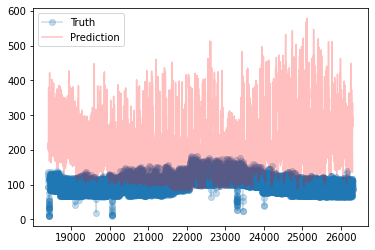

In [21]:
plot_client_pred_truth(
    idx_client=1,
    models=models_fed,
    train_samples=False,
    timesteps=t_test
    )

### III. Central drive

Here, we leave the decentralized context, where we train one model per node. This time, we are in the classic case: the data form a complete centralized dataset. A model is trained from this complete dataset (all data).

In this context, correlations between variables $k=1 \dots K$ influence the learned model. It is important to understand that in stages I. and II. these correlations are ignored by construction (consequently the models of stages I. and II. are based only on the observed values of each of the variables).

In [22]:
# scale the data
## one scaler for the whole dataset as we only have a centralized one
scaler =  StandardScaler(with_mean=True, with_std=True)

train_dataset = SequenceDataset(
    scaler.fit_transform(x_data[:T_train, :n_clients]), lag=lag
    )
test_dataset = SequenceDataset(
    scaler.transform(x_data[T_train:, :n_clients]), lag=lag
    )

batch_size = 2**3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
num_hidden_units = 5 #50
model_cent = ShallowForecastLSTM(num_var=n_clients, hidden_units=num_hidden_units)

In [24]:
# train the model
loss_function = nn.MSELoss()
learning_rate = 1e-2
optimizer = Adam(model_cent.parameters(), lr=learning_rate, betas=(0.6, 0.75))
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

print("Untrained test\n--------")
test_model(test_loader, model_cent, loss_function)

train_loss_epoch = np.empty(n_epoch)
test_loss_epoch = np.empty(n_epoch)

for i_epoch in range(n_epoch):
    print(f"Epoch {i_epoch}\n---------")

    train_loss_epoch[i_epoch] = train_one_step(
        train_loader, model_cent, loss_function, optimizer=optimizer
        )[0]
    test_loss_epoch[i_epoch] = test_model(test_loader, model_cent, loss_function)
    scheduler.step(test_loss_epoch[i_epoch])

Untrained test
--------
Test loss: 0.8054461099184755
Epoch 0
---------
Train loss: 0.3465476205085382
Test loss: 0.19340935255860364
Epoch 1
---------
Train loss: 0.3119642712130534
Test loss: 0.18682268007517827
Epoch 2
---------
Train loss: 0.3122536909777014
Test loss: 0.2017042028143051
Epoch 3
---------
Train loss: 0.3077109211847044
Test loss: 0.1855926940551645
Epoch 4
---------
Train loss: 0.30862511016046557
Test loss: 0.20120417542581984
Epoch 5
---------
Train loss: 0.30827257349653464
Test loss: 0.19807177162686743
Epoch 6
---------
Train loss: 0.3065992746401827
Test loss: 0.18083427956642956
Epoch 7
---------
Train loss: 0.3070822302559528
Test loss: 0.20238733432032055
Epoch 8
---------
Train loss: 0.3066872698679683
Test loss: 0.18943369020957956
Epoch 9
---------
Train loss: 0.3070906695887951
Test loss: 0.19367757531707652
Epoch 10
---------
Train loss: 0.3070042474336152
Test loss: 0.20535566556628834
Epoch 11
---------
Train loss: 0.3074464707867567
Test loss: 0.19